# Imports and Tensorflow set up

In [4]:
# workaround if you have not yet installed CherenkovDeconvolution.py but want to try it from this notebook
import sys
sys.path.insert(0,'/net/nfshome/home/shaefs/CherenkovDeconvolution.py')

In [2]:
from cherenkovdeconvolution import dsea

import numpy as np
np.random.seed(42)

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
import csv

In [3]:
with tf.compat.v1.Session() as sess:
  devices = sess.list_devices()
devices

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 15319505623820642123),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 602626344700036944),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 22679594599, 15793251624939214974),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:1, GPU, 22679594599, 2995380063277769990),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 7988184183054583934),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:1, XLA_GPU, 17179869184, 2628298892613703555)]

# Deep Neural Network

In [5]:
# neural network
def make_model(num_features, num_classes, learning_rate=0.0005):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(120, input_shape=num_features))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(240, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(12, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    # compile the NN
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metric = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

    model.compile(optimizer=opt, loss=loss, metrics=[metric])

    return model

# Read-in and preprocessing

In [6]:
# read in data
file_path = '/net/big-tank/POOL/users/lkardum/new_mc_binning.csv'
df_raw = pd.read_csv(file_path)
df_raw

,Unnamed: 0,more_features.Type,more_features.Label_clf,more_features.confidence_1,more_features.Label_cut,more_features.cut_selected,SplineMPE.zenith,SplineMPE.azimuth,SplineMPEFitParams.nmini,SPEFit2TimeSplit1FitParams.logl,...,weight_honda_h4a,weight_astro_aachen,weight_honda_h3a,weight_full_aachen,weight_conv_mceq,weight_BERSS_h3a,weight_astro_hese6,weight_conv_mceq_epos,wieght_astro_hans,weight_conv_mceq_sibyll
0,0,2.0,1.0,1.000000,1.0,1.0,2.173209,1.450835,125.0,123.124257,...,1.362744e-10,3.356666e-13,1.329781e-10,1.466115e-10,1.513629e-10,4.255498e-13,1.326973e-11,1.665132e-10,1.978085e-12,1.514189e-10
1,2,2.0,1.0,1.000000,1.0,1.0,2.090220,2.636622,200.0,237.086697,...,2.616773e-10,1.818387e-14,2.555329e-10,2.811043e-10,2.604896e-10,5.291204e-14,6.075675e-12,2.589331e-10,2.827261e-13,2.599255e-10
2,3,2.0,1.0,1.000000,1.0,1.0,2.152436,6.229766,206.0,38.646277,...,1.275845e-10,6.482892e-14,1.245345e-10,1.370527e-10,1.340323e-10,1.262899e-13,6.840558e-12,1.470665e-10,5.969110e-13,1.344844e-10
3,4,2.0,1.0,0.994036,1.0,1.0,1.526620,3.151964,229.0,63.513442,...,1.641275e-10,1.208935e-14,1.602519e-10,1.762892e-10,1.731086e-10,3.214053e-14,2.962452e-12,1.829784e-10,1.632577e-13,1.720191e-10
4,5,4.0,2.0,0.976143,1.0,1.0,2.918809,4.037246,256.0,56.986199,...,7.372845e-11,1.381177e-13,7.195353e-11,7.928700e-11,8.272719e-11,2.100918e-13,8.138297e-12,9.102268e-11,9.758263e-13,7.895426e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,18987279,2.0,1.0,1.000000,1.0,1.0,2.172118,6.277671,219.0,49.769049,...,1.351133e-10,2.830882e-13,1.318486e-10,1.453165e-10,1.491919e-10,3.775408e-13,1.247517e-11,1.638706e-10,1.752669e-12,1.490328e-10
13336409,18987280,2.0,1.0,1.000000,1.0,1.0,1.793314,0.869684,279.0,218.336336,...,5.564235e-10,2.367969e-13,5.430380e-10,5.975786e-10,5.816988e-10,3.701852e-13,1.484627e-11,5.729662e-10,1.720888e-12,5.622095e-10
13336410,18987282,2.0,1.0,0.996024,1.0,1.0,2.338623,5.743147,314.0,73.113221,...,1.006707e-10,3.856570e-14,9.827385e-11,1.081398e-10,1.041390e-10,8.479596e-14,5.525887e-12,1.142348e-10,4.080761e-13,1.040911e-10
13336411,18987283,2.0,1.0,0.994036,1.0,1.0,2.297157,0.333139,214.0,84.905412,...,9.357208e-11,1.131404e-14,9.137286e-11,1.005215e-10,9.438675e-11,3.249545e-14,3.601112e-12,1.016194e-10,1.720724e-13,9.456591e-11


In [7]:
# drop critical rows
df = df_raw.drop([ 1007671,  1426233,  2304853,  2715790,  3674355,  3741687, 4178063,  4969266,  5038333,  5334552,  5589516,  5863719,
 5978972,  7006367,  7281704,  7509650,  8380383,  8758113,9043798, 10280382, 11179530, 11184928, 11332586, 11797767,12253944], axis = 0)

# substitute NaNs with extreme Value
df.fillna(value =-100000, inplace = True)

In [8]:
# write column names to csv
columns = df.columns.to_list()
df_temp = pd.DataFrame(data=columns)
df_temp.to_csv('output/columns.csv', index=False)
columns

['Unnamed: 0',
 'more_features.Type',
 'more_features.Label_clf',
 'more_features.confidence_1',
 'more_features.Label_cut',
 'more_features.cut_selected',
 'SplineMPE.zenith',
 'SplineMPE.azimuth',
 'SplineMPEFitParams.nmini',
 'SPEFit2TimeSplit1FitParams.logl',
 'I3MCWeightDict.InteractionType',
 'I3MCWeightDict.NEvents',
 'I3MCWeightDict.OneWeight',
 'I3MCWeightDict.PowerLawIndex',
 'I3MCWeightDict.TotalInteractionProbabilityWeight',
 'SplineMPECramerRaoParams.variance_theta',
 'SplineMPECramerRaoParams.variance_y',
 'SplineMPECramerRaoParams.covariance_theta_phi',
 'SplineMPECramerRaoParams.covariance_theta_y',
 'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy',
 'SPEFit2BayesianFitParams.nmini',
 'MuEXAngular4_rllt.value',
 'SplineMPEMuEXDifferential.energy',
 'MCPrimary.zenith',
 'MCPrimary.azimuth',
 'MCPrimary.energy',
 'MCPrimary.type',
 'SPEFit2GeoSplit2BayesianFitParams.logl',
 'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
 'HitStatisticsValuesIC.q_m

In [9]:
# Feature Selection
feature_list = ['SplineMPEDirectHitsICE.n_dir_doms', 
                        'VariousVariables.Cone_Angle',
                        'SplineMPECramerRaoParams.variance_theta',
                        'Borderness.Q_ratio_in_border',
                        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
                        'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy',
                        'SplineMPEDirectHitsICB.n_late_doms',
                        'Dustyness.n_doms_in_dust',
                        'LineFitGeoSplit1Params.n_hits',
                        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
                        'SPEFit2GeoSplit1BayesianFitParams.logl',
                        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']
#feature_list = ['MCPrimary.energy']



In [10]:
# plot correlations between the features

# plt.figure(figsize=(200,200))
# ax = sns.heatmap(df[feature_list].corr(), annot=True, square=True, cmap='coolwarm')

# #fix bug in matlotlib 3.1.0/1
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)
# plt.savefig('output/feature_cor.pdf')
# plt.show()

In [11]:
# statistical information about the energy
df['MCPrimary.energy'].describe()

count    1.333639e+07
mean     6.298949e+03
std      2.457562e+05
min      1.000001e+02
25%      2.706783e+02
50%      5.471676e+02
75%      1.416143e+03
max      9.970067e+07
Name: MCPrimary.energy, dtype: float64

In [12]:
# Variables: Label
# drop out all events with Energies outside the range
lower_limit = 100
upper_limit = 10**5

# Variables: NN
num_bins = 10 # number of bins (energy classes), output_shape

In [13]:
# throw out extreme high and low energy neutrinos
df = df[(df['MCPrimary.energy']<upper_limit) & (df['MCPrimary.energy']>lower_limit)]
df

,Unnamed: 0,more_features.Type,more_features.Label_clf,more_features.confidence_1,more_features.Label_cut,more_features.cut_selected,SplineMPE.zenith,SplineMPE.azimuth,SplineMPEFitParams.nmini,SPEFit2TimeSplit1FitParams.logl,...,weight_honda_h4a,weight_astro_aachen,weight_honda_h3a,weight_full_aachen,weight_conv_mceq,weight_BERSS_h3a,weight_astro_hese6,weight_conv_mceq_epos,wieght_astro_hans,weight_conv_mceq_sibyll
0,0,2.0,1.0,1.000000,1.0,1.0,2.173209,1.450835,125.0,123.124257,...,1.362744e-10,3.356666e-13,1.329781e-10,1.466115e-10,1.513629e-10,4.255498e-13,1.326973e-11,1.665132e-10,1.978085e-12,1.514189e-10
1,2,2.0,1.0,1.000000,1.0,1.0,2.090220,2.636622,200.0,237.086697,...,2.616773e-10,1.818387e-14,2.555329e-10,2.811043e-10,2.604896e-10,5.291204e-14,6.075675e-12,2.589331e-10,2.827261e-13,2.599255e-10
2,3,2.0,1.0,1.000000,1.0,1.0,2.152436,6.229766,206.0,38.646277,...,1.275845e-10,6.482892e-14,1.245345e-10,1.370527e-10,1.340323e-10,1.262899e-13,6.840558e-12,1.470665e-10,5.969110e-13,1.344844e-10
3,4,2.0,1.0,0.994036,1.0,1.0,1.526620,3.151964,229.0,63.513442,...,1.641275e-10,1.208935e-14,1.602519e-10,1.762892e-10,1.731086e-10,3.214053e-14,2.962452e-12,1.829784e-10,1.632577e-13,1.720191e-10
4,5,4.0,2.0,0.976143,1.0,1.0,2.918809,4.037246,256.0,56.986199,...,7.372845e-11,1.381177e-13,7.195353e-11,7.928700e-11,8.272719e-11,2.100918e-13,8.138297e-12,9.102268e-11,9.758263e-13,7.895426e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,18987279,2.0,1.0,1.000000,1.0,1.0,2.172118,6.277671,219.0,49.769049,...,1.351133e-10,2.830882e-13,1.318486e-10,1.453165e-10,1.491919e-10,3.775408e-13,1.247517e-11,1.638706e-10,1.752669e-12,1.490328e-10
13336409,18987280,2.0,1.0,1.000000,1.0,1.0,1.793314,0.869684,279.0,218.336336,...,5.564235e-10,2.367969e-13,5.430380e-10,5.975786e-10,5.816988e-10,3.701852e-13,1.484627e-11,5.729662e-10,1.720888e-12,5.622095e-10
13336410,18987282,2.0,1.0,0.996024,1.0,1.0,2.338623,5.743147,314.0,73.113221,...,1.006707e-10,3.856570e-14,9.827385e-11,1.081398e-10,1.041390e-10,8.479596e-14,5.525887e-12,1.142348e-10,4.080761e-13,1.040911e-10
13336411,18987283,2.0,1.0,0.994036,1.0,1.0,2.297157,0.333139,214.0,84.905412,...,9.357208e-11,1.131404e-14,9.137286e-11,1.005215e-10,9.438675e-11,3.249545e-14,3.601112e-12,1.016194e-10,1.720724e-13,9.456591e-11


# Discretize the target Neutrino Energy

In [14]:
## log-scaled Binning
#bins = np.logspace(np.log10(lower_limit), np.log10(upper_limit), num_bins+1)
#bins

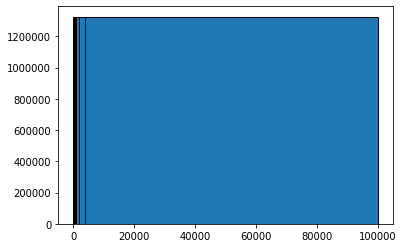

(array([  100.00006179,   170.95245193,   234.25673359,   309.10591847,
          406.48116436,   542.58234032,   749.34829468,  1101.66579579,
         1821.7474251 ,  4020.7794041 , 99995.412707  ]),
 array([1326210., 1326209., 1326210., 1326209., 1326209., 1326210.,
        1326209., 1326210., 1326209., 1326209.]))

In [15]:
# Equal-frequency Binning

#define function to calculate equal-frequency bins 
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(df['MCPrimary.energy'].to_numpy(), equalObs(df['MCPrimary.energy'].to_numpy(), num_bins), edgecolor='black')
plt.show()

#display bin boundaries and frequency per bin 
bins, n

In [16]:
# new column with discretized energies

df['E_discr'] = pd.cut(df['MCPrimary.energy'], bins=bins, labels=range(len(bins)-1))
df['E_discr'].value_counts()

7    1326210
4    1326210
2    1326210
9    1326209
8    1326209
6    1326209
5    1326209
3    1326209
1    1326209
0    1326209
Name: E_discr, dtype: int64

# Create target dataset

In [17]:
# one hot encoded vector (necessary for cce)
df_E_dummie = pd.get_dummies(df['E_discr'])
df_E_dummie

E_discr,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
13336408,0,0,0,0,0,0,0,0,1,0
13336409,0,0,0,0,0,0,0,1,0,0
13336410,0,0,0,0,0,1,0,0,0,0
13336411,0,1,0,0,0,0,0,0,0,0


In [18]:
# target
y = df_E_dummie.to_numpy()
y.shape

(13262094, 10)

In [19]:
X = df[feature_list].to_numpy()
X.shape

(13262094, 12)

In [20]:
# subsample size

def create_dataset(X, y, subset=0, validation_split=0.2):
    # X,y: numpy Array
    # subset: size of the subset (Int)
    # validation_split: (0, 1) 
    perm = np.random.permutation(len(X))

    if subset:
        perm = perm[0:subset]

    limit = int(len(perm)*(1-validation_split))

    X_train = X[perm[:limit]]
    X_eval = X[perm[limit:]]
    y_train = y[perm[:limit]]
    y_eval = y[perm[limit:]]

    return X_train, y_train, X_eval, y_eval

In [21]:
X_train, y_train, X_eval, y_eval = create_dataset(X, y, validation_split=0.2, subset=0)
print(X_train.shape, y_train.shape, X_eval.shape, y_eval.shape)

(10609675, 12) (10609675, 10) (2652419, 12) (2652419, 10)


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_eval = scaler.transform(X_eval)

# Training process

In [23]:
# for the right training loss curve
class HistoryEpoch(tf.keras.callbacks.Callback):
    def __init__(self, data):
        self.data = data        
        
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        self.loss.append(l)
        self.acc.append(a)

In [24]:
train_hist = HistoryEpoch((X_train, y_train))
eval_hist = HistoryEpoch((X_eval, y_eval))

In [25]:
model = make_model(num_features=(len(feature_list), ), num_classes=num_bins, learning_rate=0.0005)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               1560      
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 240)               29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               28920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1

In [26]:
history = model.fit(X_train, y_train, batch_size=2048, epochs=20, validation_data=(X_eval, y_eval)) #, callbacks=[train_hist, eval_hist]

Train on 10609675 samples, validate on 2652419 samples
Epoch 1/20
10609675/10609675 [==============================] - 26s 2us/sample - loss: 1.9401 - categorical_accuracy: 0.2496 - val_loss: 1.9169 - val_categorical_accuracy: 0.2573
Epoch 2/20
10609675/10609675 [==============================] - 23s 2us/sample - loss: 1.9233 - categorical_accuracy: 0.2550 - val_loss: 1.9106 - val_categorical_accuracy: 0.2589
Epoch 3/20
10609675/10609675 [==============================] - 22s 2us/sample - loss: 1.9187 - categorical_accuracy: 0.2568 - val_loss: 1.9070 - val_categorical_accuracy: 0.2615
Epoch 4/20
10609675/10609675 [==============================] - 22s 2us/sample - loss: 1.9142 - categorical_accuracy: 0.2591 - val_loss: 1.9008 - val_categorical_accuracy: 0.2640
Epoch 5/20
10609675/10609675 [==============================] - 22s 2us/sample - loss: 1.9110 - categorical_accuracy: 0.2606 - val_loss: 1.8993 - val_categorical_accuracy: 0.2650
Epoch 6/20
10609675/10609675 [====================

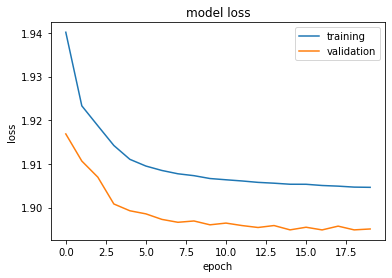

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

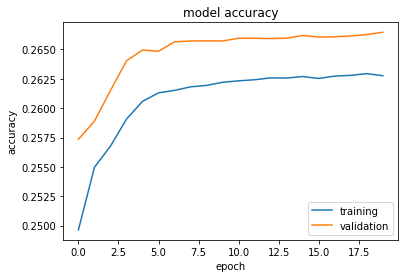

In [28]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [29]:
model.save('models/model_4L_Dropout_equal')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/model_4L_Dropout_equal/assets


# Predict data / Evaluation

In [30]:
# propability for each class
y_pred =model.predict(X_train)
y_pred

array([[0.01601269, 0.12034833, 0.17625447, ..., 0.07923646, 0.05851317,
        0.02946605],
       [0.00021799, 0.01598895, 0.07574855, ..., 0.14516883, 0.1256613 ,
        0.06833204],
       [0.03504556, 0.17459542, 0.19982949, ..., 0.05967807, 0.03984037,
        0.0180996 ],
       ...,
       [0.01319889, 0.0895792 , 0.15919921, ..., 0.08265718, 0.06322125,
        0.03565438],
       [0.04260914, 0.15565124, 0.18140286, ..., 0.06490062, 0.04592437,
        0.02338673],
       [0.00917677, 0.09320375, 0.16397172, ..., 0.08456966, 0.06328812,
        0.03356166]], dtype=float32)

In [31]:
# choose class with max value
y_pred_max = np.zeros_like(y_pred)
y_pred_max[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
y_pred_max

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

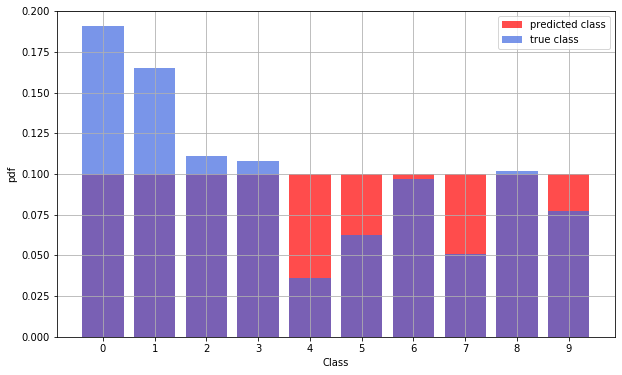

In [32]:
plt.figure(figsize=(10,6))
plt.bar(np.arange(10), y_train.sum(axis=0)/y_train.sum(), alpha=0.7, color='red', label='predicted class')
plt.bar(np.arange(10), y_pred_max.sum(axis=0)/y_train.sum(), alpha=0.7, color='royalblue', label='true class')

plt.legend()
plt.grid()
plt.xlabel('Class')
plt.ylabel('pdf')
plt.xticks(np.arange(10))
plt.savefig('output/hist_equal.pdf')
plt.show()

In [33]:
# centers of the bin limits (size reduced by 1)
bin_centers = [(bins[i] + (bins[i+1]-bins[i])/2) for i in range(len(bins)-1)]

In [34]:
# from one-hot encoded vector label to integer
y_train_cls = np.argmax(y_train, axis=1)
y_pred_cls = np.argmax(y_pred_max, axis=1)
np.unique(y_train_cls)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
# from integer label to energy
y_train_energy = np.zeros_like(y_train_cls)
y_pred_energy = np.zeros_like(y_pred_cls)

for i in range(len(bin_centers)):
    y_train_energy = np.where(y_train_cls==i, bin_centers[i], y_train_energy)
    y_pred_energy = np.where(y_pred_cls==i, bin_centers[i], y_pred_energy)

np.unique(y_train_energy)

array([  135.47625686,   202.60459276,   271.68132603,   357.79354142,
         474.53175234,   645.9653175 ,   925.50704524,  1461.70661045,
        2921.2634146 , 52008.09605555])

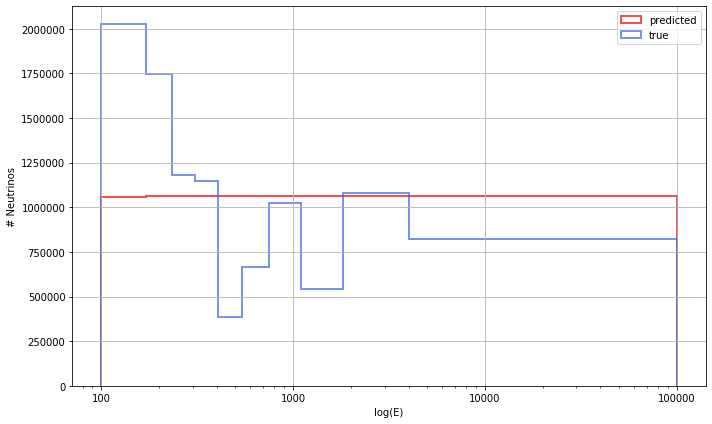

In [36]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(y_train_energy, bins=bins, alpha=0.7, color='red', histtype='step', linewidth=2, label='predicted')
ax1.hist(y_pred_energy, bins=bins, alpha=0.7, color='royalblue', histtype='step', linewidth=2, label='true')


ax1.set_xscale('log')
#ax1.set_xticks(bin_centers)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel('log(E)')

ax1.set_ylabel('# Neutrinos')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('output/hist_equal_energy.pdf')
plt.show()

## Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_pred_cls, y_train_cls)

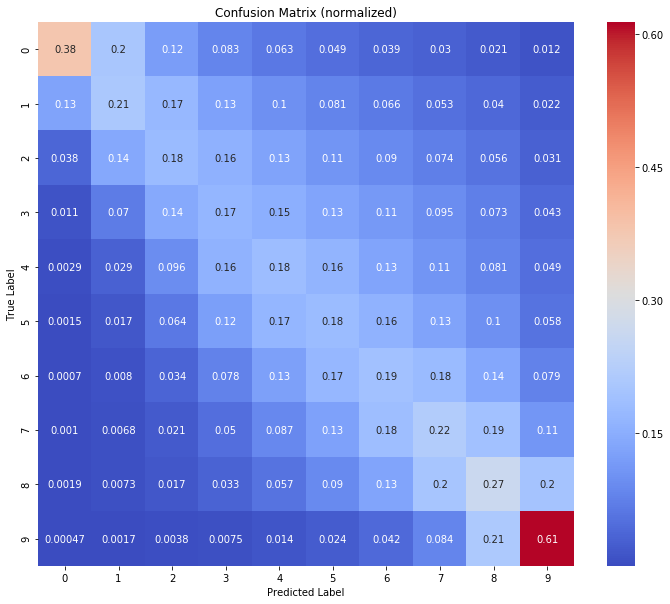

In [38]:
df_cm = pd.DataFrame(confusion_mtx/confusion_mtx.sum(axis=1)[:, np.newaxis])
plt.figure(figsize=(12,10))
#fix bug in matlotlib 3.1.0/1

ax = sns.heatmap(df_cm, annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (normalized)')
plt.savefig('output/cm_equal.pdf')
plt.show()

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
print('Evaluation on Training data:\r')
print('Accuracy: %.4f' % accuracy_score(y_train, y_pred_max))
print("Precision: %.4f" % precision_score(y_train, y_pred_max, average='weighted'))
print("Recall: %.4f" % recall_score(y_train, y_pred_max, average='weighted'))
print(classification_report(y_train, y_pred_max))

Evaluation on Training data:
Accuracy: 0.2660
Precision: 0.2578
Recall: 0.2660


/opt/anaconda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.38      0.73      0.50   1060098
           1       0.21      0.34      0.26   1061131
           2       0.18      0.20      0.19   1061239
           3       0.17      0.18      0.17   1060945
           4       0.18      0.07      0.10   1061124
           5       0.18      0.11      0.14   1060972
           6       0.19      0.18      0.19   1061290
           7       0.22      0.11      0.15   1060690
           8       0.27      0.27      0.27   1061515
           9       0.61      0.47      0.54   1060670

   micro avg       0.27      0.27      0.27  10609674
   macro avg       0.26      0.27      0.25  10609674
weighted avg       0.26      0.27      0.25  10609674
 samples avg       0.27      0.27      0.27  10609674



In [40]:
from sklearn.metrics import jaccard_score
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
#'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account

jaccard_score = jaccard_score(y_train, y_pred_max, average='micro')
print('Jaccard-Score: %.4f' % jaccard_score)

Jaccard-Score: 0.1534
